## Testing rendering pictures with [ray multiprocessing](https://docs.ray.io/en/latest/index.html)

This notebooks demonstrates how ray workers can update matplotlib figures run in a central notebook.
The pattern provides is fairly simple with a central `queue` into which all workers shift their `data`. The main (Jupyter) thread waits for the queue to be filled and updates the respective plot.
The code below also demonstrates how to clean up a ray job.

/Imported


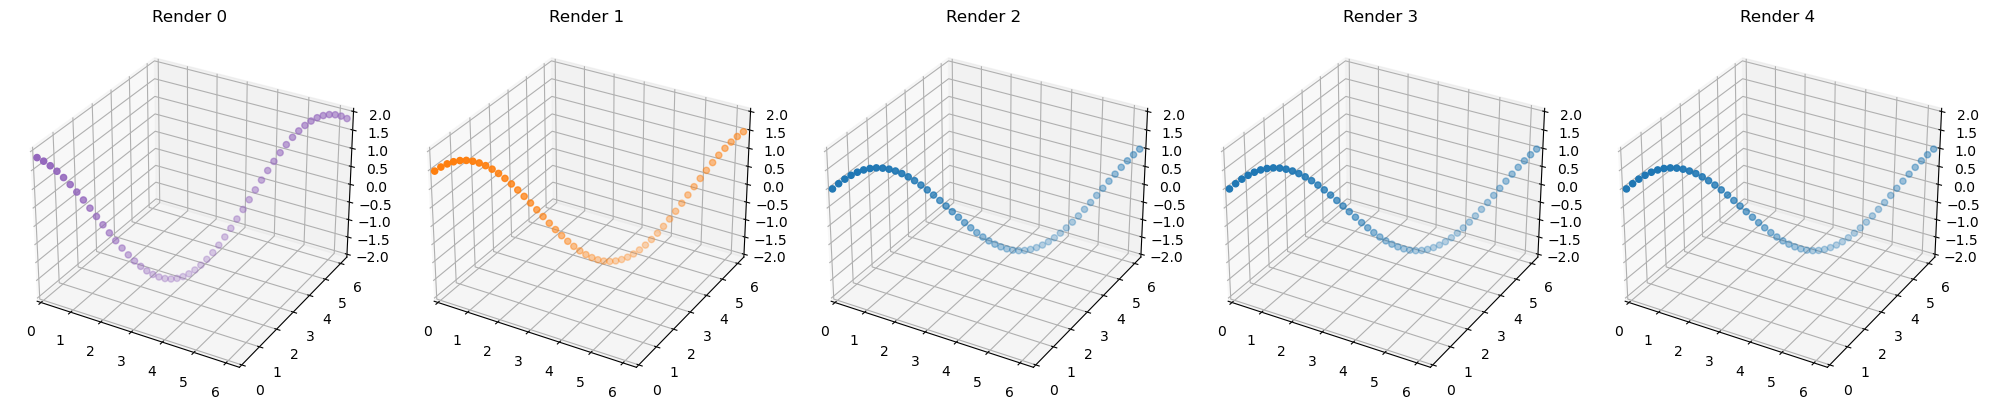

Launch
Simple update loop starting
(run pid=29908) Run 2 starting with a waiting time of 0.871177
(run pid=13928) Run 3 starting with a waiting time of 0.566719
(run pid=35404) Run 1 starting with a waiting time of 0.326219
(run pid=19128) Run 0 starting with a waiting time of 0.0850894
(run pid=33964) Run 4 starting with a waiting time of 0.788287
Got data from 4
Got data from 1
(run pid=19128) Run 0 done
Got data from 2
Got data from 0
Got data from 3
Got data from 0
Got data from 0
(run pid=35404) Run 1 done
Got data from 0
Got data from 1
Got data from 0
Ctrl+C
Render is done
Deleting server


C:\Users\hansb\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


(run pid=13928) Task 3 KeyboardInterrupt
(run pid=33964) Task 4 KeyboardInterrupt
(run pid=29908) Task 2 KeyboardInterrupt
/Done


In [14]:
%matplotlib inline

import ray
import numpy as np
import math
import time
import io
import random
import cdxbasics.dynaplot as dynaplot
from cdxbasics.prettydict import PrettyDict as pdct
from IPython.display import display, Image
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import ray.util.queue as ray_queue
import asyncio as asyncio

print("/Imported")

class Renderer(object):
    """
    Represents a single plot. Each plot is owned by an asynchronous process.
    """
    
    def __init__(self, fig, ix):        
        self.fig   = fig
        self.ax    = self.fig.add_subplot(projection='3d')
        self.ax.set_xlim(0.,2.*math.pi)
        self.ax.set_ylim(0.,2.*math.pi)
        self.ax.set_zlim(-2,+2)
        self.ax.set_title("Render %ld" % ix)
        self.r     = None
        self.ix    = ix
        
    def update( self, data ):
        if not self.r is None: self.r.remove()
        self.r = self.ax.scatter( data.x, data.y, data.z )


class Server(object):
    """
    Contains the shared components for our Ray driven plotting
    """

    def __init__(self):
        self.N         = 5
        self.queue     = ray_queue.Queue()
        self.fig       = dynaplot.figure()
        self.renderers = [ Renderer(self.fig, i) for i in range(self.N) ]
        self.cnt_done  = 0
        self.fig.render()

    async def update(self):
        print("Update loop starting")
        while True:
            data = self.queue.get()
            ix = data.ix
            if data.done:
                self.cnt_done += 1
                if self.cnt_done >= 5:
                    print("Update loop done")
                    return
            else:
                self.renderers[ix].update(data)
                self.fig.render()

    def simple_update(self):
        print("Simple update loop starting")
        while True:
            data = self.queue.get()
            ix = data.ix
            print("Got data from %ld" % ix)
            if data.done:
                self.cnt_done += 1
                if self.cnt_done >= 5:
                    print("Simple update loop done")
                    return
            else:
                self.renderers[ix].update(data)
                self.fig.render()

server = Server()

@ray.remote
def run(queue, ix):
    """
    Remote function which computes the updates for each plot
    """
    try:
        x = np.linspace(0.,2.*math.pi,51)
        y = x
        w = 1. * random.uniform(0,1)
        print("Run %ld starting with a waiting time of %g" % (ix, w))
        for i in range(20):
            time.sleep(w)
            z = np.cos( float(i)/10.+x )+np.sin( float(i)/2.+y )
            queue.put( pdct(ix=ix,x=x,y=y,z=z,done=False) )
        queue.put( pdct(ix=ix,done=True) )
        print("Run %ld done" % ix)
    except ray.exceptions.TaskCancelledError:
        print("Task %ld cancelled" % ix)
    except KeyboardInterrupt:
        print("Task %ld KeyboardInterrupt" % ix)

"""
Launch ray'd plotting
"""
#import signal
#signal.signal(signal.SIGINT, signal.SIG_DFL)
print("Launch")

futures = [ run.remote(server.queue, r.ix) for r in server.renderers ]

try:
    server.simple_update()
except KeyboardInterrupt:
    print("Ctrl+C")

for f in futures:
    ray.cancel( f )
    
print("Render is done")

"""
    #ray.get(futures)
"""
print("Deleting server")
del server
print("/Done")





In [5]:
help(f)

Help on ObjectRef object:

class ObjectRef(BaseID)
 |  ObjectRef(id, owner_addr=u'', call_site_data=u'', skip_adding_local_ref=False)
 |  
 |  Method resolution order:
 |      ObjectRef
 |      BaseID
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __await__(...)
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  as_future(...)
 |      ObjectRef.as_future(self, _internal=False) -> asyncio.Future
 |      Wrap ObjectRef with an asyncio.Future.
 |      
 |              Note that the future cancellation will not cancel the correspoding
 |              task when the ObjectRef representing return object of a task.
 |  
 |  binary(...)
 |      ObjectRef.binary(self)
 |  
 |  call_site(...)
 |      ObjectRef.call_site(self)
 |  
 |  future(...)
 |      ObjectRef.future(self) -> concurrent.futures.Future
 |      Wrap ObjectRef with a concurrent.futures.Future
 |      
 |              Note that the future ca

In [6]:
help(ray)

Help on package ray:

NAME
    ray - # isort: skip_file

PACKAGE CONTENTS
    _private (package)
    _raylet
    actor
    air (package)
    autoscaler (package)
    client_builder
    cloudpickle (package)
    cluster_utils
    core (package)
    cross_language
    dag (package)
    dashboard (package)
    data (package)
    exceptions
    experimental (package)
    internal (package)
    job_config
    job_submission (package)
    ray_operator (package)
    remote_function
    rllib (package)
    runtime_context
    runtime_env (package)
    scripts (package)
    serve (package)
    setup-dev
    train (package)
    tune (package)
    types
    util (package)
    widgets (package)
    workflow (package)

CLASSES
    builtins.object
        ray._raylet.Language
        ray.client_builder.ClientBuilder
    ray._raylet.BaseID(builtins.object)
        ray._raylet.ActorID
        ray._raylet.JobID
        ray._raylet.ObjectRef
        ray._raylet.PlacementGroupID
        ray._raylet.TaskI